In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ABIDE

Mounted at /content/drive
/content/drive/MyDrive/ABIDE


In [ ]:
!pip install nilearn
!pip install wandb

import os
import shutil

from keras import regularizers
import matplotlib.pyplot as plt
from nilearn.image import load_img
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.input_data import NiftiLabelsMasker
import numpy as npva
import pandas as pd
from PIL import ImageFile
from scipy.sparse import issparse
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam, RMSprop
from tqdm import tqdm
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
# Hyperparameters
pheno_dataset = "Phenotypic_V1_0b_preprocessed1.csv"
working_dir = '/content/drive/MyDrive/ABIDE'
image_dir = "func_preproc"
pheno_vars = ["AGE_AT_SCAN", "SEX"]
pheno_weight = 100
test_size = 0.2
regularization_lambda = 0.001
k_fold_splits = 8
leaky_RELU_alpha = 0.1
dropout = 0.2
epochs = 500
learning_rate = 0.01
patience = 7
batch_size = 32

WANDB_API_KEY = None

if WANDB_API_KEY:
    run = wandb.init(
        project = "Neurological Categories",
        config = {
            "pheno_weight": pheno_weight,
            "test_size": test_size,
            "regularization_lambda": regularization_lambda,
            "k_fold_splits": k_fold_splits,
            "leaky_RELU_alpha": leaky_RELU_alpha,
            "dropout": dropout,
            "learning_rate": learning_rate,
            "patience": patience,
            "epochs": epochs,
            "batch_size": batch_size,
        },
        settings=wandb.Settings(init_timeout=150)
    )


In [ ]:
# Fetch the atlas with 100 regions of interest (ROIs)
atlas = fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)

[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

In [ ]:
# Function to extract subject ID from the filename
def get_id(name):
    parts = name.split('_')
    for part in parts:
        if part.isdigit():
            return part.lstrip('0')
    return None

imaging_files = os.listdir(image_dir)
image_ids = [get_id(f) for f in imaging_files if get_id(f)]
print(f"Number of imaging files: {len(imaging_files)}")
print(f"First 10 extracted image IDs: {image_ids[:10]}")

# Load the phenotypic data
phenotypic_data = pd.read_csv(pheno_dataset)
phenotypic_data['SUB_ID'] = phenotypic_data['SUB_ID'].astype(str).str.strip()
print("First 10 SUB_IDs in phenotypic data:", phenotypic_data['SUB_ID'])

# Match phenotypic data with imaging data
matched_data = phenotypic_data[phenotypic_data['SUB_ID'].isin(image_ids)].reset_index(drop=True)
print(f"Number of matched subjects: {len(matched_data)}")

Number of imaging files: 257
First 10 extracted image IDs: ['50014', '50025', '50041', '50042', '50045', '50047', '50052', '50104', '50107', '50112']
First 10 SUB_IDs in phenotypic data: 0       50002
1       50003
2       50004
3       50005
4       50006
        ...  
1107    51583
1108    51584
1109    51585
1110    51606
1111    51607
Name: SUB_ID, Length: 1112, dtype: object
Number of matched subjects: 182


First 10 extracted image IDs: ['50045', '50133', '50143', '50144', '50153', '50118', '50112', '50168', '50166', '50169']
First 10 SUB_IDs in phenotypic data: 0       50002
1       50003
2       50004
3       50005
4       50006
        ...  
1107    51583
1108    51584
1109    51585
1110    51606
1111    51607
Name: SUB_ID, Length: 1112, dtype: object


In [ ]:
fmri_directory_drive = f"{working_dir}/{image_dir}"
fmri_files = os.listdir(fmri_directory_drive)
print(f"Files in '{fmri_directory_drive}':")
print(fmri_files)

file_to_check = 'Pitt_0050041_func_preproc.nii.gz'
if file_to_check in fmri_files:
    print(f"File '{file_to_check}' exists in '{fmri_directory_drive}'.")
else:
    print(f"File '{file_to_check}' does NOT exist in '{fmri_directory_drive}'.")

# Change current working directory
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

local_directory = f"/content/{image_dir}"
if not os.path.exists(local_directory):
    os.makedirs(local_directory)

imaging_files = os.listdir(fmri_directory_drive)
for fmri_file in imaging_files:
    shutil.copy(f"{fmri_directory_drive}/{fmri_file}", local_directory)

Files in '/content/drive/MyDrive/ABIDE/func_preproc':
['Pitt_0050014_func_preproc.nii.gz', 'Pitt_0050025_func_preproc.nii.gz', 'Pitt_0050041_func_preproc.nii.gz', 'Pitt_0050042_func_preproc.nii.gz', 'Pitt_0050045_func_preproc.nii.gz', 'Pitt_0050047_func_preproc.nii.gz', 'Pitt_0050052_func_preproc.nii.gz', 'Olin_0050104_func_preproc.nii.gz', 'Olin_0050107_func_preproc.nii.gz', 'Olin_0050112_func_preproc.nii.gz', 'Olin_0050118_func_preproc.nii.gz', 'Olin_0050125_func_preproc.nii.gz', 'Olin_0050133_func_preproc.nii.gz', 'OHSU_0050143_func_preproc.nii.gz', 'OHSU_0050144_func_preproc.nii.gz', 'OHSU_0050153_func_preproc.nii.gz', 'OHSU_0050166_func_preproc.nii.gz', 'OHSU_0050168_func_preproc.nii.gz', 'OHSU_0050169_func_preproc.nii.gz', 'OHSU_0050170_func_preproc.nii.gz', 'SDSU_0050182_func_preproc.nii.gz', 'SDSU_0050187_func_preproc.nii.gz', 'SDSU_0050188_func_preproc.nii.gz', 'SDSU_0050190_func_preproc.nii.gz', 'SDSU_0050191_func_preproc.nii.gz', 'SDSU_0050194_func_preproc.nii.gz', 'SDSU_005

In [ ]:
# Fetch the atlas
atlas = fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
scaler = StandardScaler()

def gen_features_and_labels(data, target_feature, image_dir, pheno_variables, pheno_weight):
    features_list = []
    labels_list = []

    for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
        sub_id = row['SUB_ID']
        fmri_file = next((f for f in imaging_files if sub_id in f), None)
        if fmri_file:
            fmri_file_path = f"/content/{image_dir}/{fmri_file}"
            if os.path.exists(fmri_file_path):
                try:
                    fmri_img = load_img(fmri_file_path)

                    time_series = masker.fit_transform(fmri_img)
                    time_series = np.nan_to_num(time_series, nan=0.0, posinf=0.0, neginf=0.0)
                    correlation_matrix = np.corrcoef(time_series.T)
                    correlation_matrix = np.nan_to_num(correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

                    fmri_features = squareform(correlation_matrix, checks=False)
                    scaled_fmri_features = scaler.fit_transform(fmri_features.reshape(-1, 1)).flatten()  # reshape for 1D scaling

                    pheno_features = row[pheno_variables].values
                    pheno_features = np.array(pheno_features)

                    scaled_pheno_features = scaler.fit_transform(pheno_features.reshape(-1, 1)).flatten()
                    combined_features = np.concatenate((fmri_features, pheno_weight*scaled_pheno_features))
                    # combined_features = np.concatenate((fmri_features, pheno_weight*pheno_features))
                    features_list.append(combined_features)
                    labels_list.append(row[target_feature])
                except (Exception) as e:
                    print(f"Error loading file '{fmri_file_path}': {e}")
            else:
                print(f"File '{fmri_file_path}' does not exist.")
        else:
            print(f"No fMRI file found for subject {sub_id}")
    return features_list, labels_list

def gen_labels(data, target_feature, image_dir):
    labels_list = []

    for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
        sub_id = row['SUB_ID']
        fmri_file = next((f for f in imaging_files if sub_id in f), None)
        if fmri_file:
            fmri_file_path = f"/content/{image_dir}/{fmri_file}"
            if os.path.exists(fmri_file_path):
                labels_list.append(row[target_feature])
            else:
                print(f"File '{fmri_file_path}' does not exist.")
        else:
            print(f"No fMRI file found for subject {sub_id}")
    return labels_list


[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

In [ ]:
# labels_list = gen_labels(matched_data, "DX_GROUP",  image_dir)
features_list, labels_list = gen_features_and_labels(matched_data, "DX_GROUP",  image_dir, pheno_vars, pheno_weight)

 39%|███▉      | 71/182 [10:45<17:25,  9.42s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 95%|█████████▌| 173/182 [25:11<01:08,  7.64s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 182/182 [26:30<00:00,  8.74s/it]


In [ ]:
# Assuming feature extraction is complete and features_list and labels_list are populated

X = np.array(features_list)
y = np.array(labels_list)

# Encode labels: 1 -> 1 (ASD), 2 -> 0 (Control)
y_encoded = (y == 1).astype(int)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Replace any NaN or inf values in features
X = np.nan_to_num(X)
X = X.astype(np.float32)

In [ ]:
print(len(features_list[0]))
# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr + 0.0001  # Gradually increase during warm-up
    return lr * 0.95  # Gradually decrease after epoch 10

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# regularization = regularizers.l2(0.001)

kfold = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=42)
fold_accuracies = []

for train_idx, val_idx in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights = dict(enumerate(class_weights))
    model = models.Sequential([
        layers.Input(shape=(X_train_fold.shape[1],)),
        layers.Dense(256),
        # layers.Dense(256, kernel_regularizer=regularization),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(128),
        # layers.Dense(128, kernel_regularizer=regularization),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(64),
        # layers.Dense(64, kernel_regularizer=regularization),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(32),
        # layers.Dense(32, kernel_regularizer=regularization),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    lr_scheduler_callback = callbacks.LearningRateScheduler(lr_schedule, verbose=1)
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold),
                        class_weight=class_weights,
                        callbacks=[early_stopping, lr_scheduler_callback],
                        verbose=0)
    score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(score[1])
    print(f"Fold Test Accuracy: {score[1] * 100:.2f}%")
    if WANDB_API_KEY:
        wandb.log({
            "Fold Test Accuracy": score[1] * 100,
            "Learning rate": model.optimizer.lr.numpy()
            }
        )

print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies) * 100:.2f}%")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
if WANDB_API_KEY:
    wandb.log({
        "Test Accuracy": test_accuracy,
        "Learning rate": model.optimizer.lr.numpy()
        }
    )


4952
Training set size: 145 samples
Testing set size: 37 samples

Epoch 1: LearningRateScheduler setting learning rate to 0.0006000000237487257.

Epoch 2: LearningRateScheduler setting learning rate to 0.0007000000284984708.

Epoch 3: LearningRateScheduler setting learning rate to 0.000800000033248216.

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000379979611.

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000427477062.

Epoch 6: LearningRateScheduler setting learning rate to 0.0011000000474974514.

Epoch 7: LearningRateScheduler setting learning rate to 0.0011999999940395356.

Epoch 8: LearningRateScheduler setting learning rate to 0.0012999999405816198.

Epoch 9: LearningRateScheduler setting learning rate to 0.001399999887123704.

Epoch 10: LearningRateScheduler setting learning rate to 0.0014999998336657882.
Fold Test Accuracy: 63.16%

Epoch 1: LearningRateScheduler setting learning rate to 0.0006000000237487257.

Epoch 2: LearningRateSchedul

In [ ]:

# Scores for receptive communication, expressive communication, written communication, interpersonal skills, coping skills, processing speed
personality_variables = ["VINELAND_RECEPTIVE_V_SCALED", "VINELAND_EXPRESSIVE_V_SCALED",
                        "VINELAND_WRITTEN_V_SCALED", "VINELAND_INTERPERSONAL_V_SCALED",
                        "VINELAND_COPING_V_SCALED", "WISC_IV_PSI"]

personality_dictionary = {
  "choleric": {"Pos":["WISC_IV_PSI"], "Neg": ["VINELAND_RECEPTIVE_V_SCALED", "VINELAND_INTERPERSONAL_V_SCALED", "VINELAND_COPING_V_SCALED"]},
  "sanguine": {"Pos":["VINELAND_EXPRESSIVE_V_SCALED", "VINELAND_INTERPERSONAL_V_SCALED"], "Neg": ["VINELAND_WRITTEN_V_SCALED"]},
  "phlegmatic": {"Pos":["VINELAND_RECEPTIVE_V_SCALED", "VINELAND_COPING_V_SCALED"], "Neg": ["WISC_IV_PSI"]},
  "melancholic": {"Pos":["VINELAND_WRITTEN_V_SCALED"], "Neg": ["VINELAND_EXPRESSIVE_V_SCALED"]}
}

def standardise_all(variables, phenotypic_data):
  for variable in variables:
    phenotypic_data[variable + "_STANDARD"] = (phenotypic_data[variable] - phenotypic_data[variable].mean())/phenotypic_data[variable].std()
  return phenotypic_data

def get_personality_score(personality_type, personality_dictionary, row):
  pos = np.mean([row[variable + "_STANDARD"] for variable in personality_dictionary[personality_type]["Pos"]])
  neg = np.mean([row[variable + "_STANDARD"] for variable in personality_dictionary[personality_type]["Neg"]])
  return pos - neg

def get_personality(personality_dictionary, row):
  choleric_score = get_personality_score("choleric", personality_dictionary, row)
  sanguine_score = get_personality_score("sanguine", personality_dictionary, row)
  phlegmatic_score = get_personality_score("phlegmatic", personality_dictionary, row)
  melancholic_score = get_personality_score("melancholic", personality_dictionary, row)
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == choleric_score:
    return "choleric"
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == sanguine_score:
    return "sanguine"
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == phlegmatic_score:
    return "phlegmatic"
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == melancholic_score:
    return "melancholic"

def get_personalities(personality_dictionary, phenotypic_data):
  personalities = []
  for idx, row in tqdm(phenotypic_data.iterrows(), total=phenotypic_data.shape[0]):
    personalities.append(get_personality(personality_dictionary, row))
  return personalities

def add_personalities(personality_dictionary, phenotypic_data):
  for idx, row in tqdm(phenotypic_data.iterrows(), total=phenotypic_data.shape[0]):
    phenotypic_data.loc[idx, "PERSONALITY"] = get_personality(personality_dictionary, row)
    phenotypic_data.loc[idx, "choleric_score"] = get_personality_score("choleric", personality_dictionary, row)
    phenotypic_data.loc[idx, "sanguine_score"] = get_personality_score("sanguine", personality_dictionary, row)
    phenotypic_data.loc[idx, "phlegmatic_score"] = get_personality_score("phlegmatic", personality_dictionary, row)
    phenotypic_data.loc[idx, "melancholic_score"] = get_personality_score("melancholic", personality_dictionary, row)
  return phenotypic_data

matched_data = standardise_all(personality_variables, matched_data)
personality_labels = get_personalities(personality_dictionary, matched_data)
matched_data = add_personalities(personality_dictionary, matched_data)
phenotypic_data.to_csv("with_personalities.csv", encoding='utf-8')


100%|██████████| 182/182 [00:00<00:00, 696.83it/s]


In [ ]:
# Hyperparameters
image_dir = "func_preproc"
pheno_vars = ["AGE_AT_SCAN", "SEX"]
pheno_weight = 1000
test_size = 0.2
regularization_lambda = 0.001
k_fold_splits = 8
leaky_RELU_alpha = 0.1
dropout = 0.1
learning_rate = 0.01
patience = 20
epochs = 300
batch_size = 16

WANDB_API_KEY = None

if WANDB_API_KEY:
    run = wandb.init(
        project = "Personality classification",
        config = {
            pheno_weight: pheno_weight,
            test_size: test_size,
            regularization_lambda: regularization_lambda,
            k_fold_splits: k_fold_splits,
            leaky_RELU_alpha: leaky_RELU_alpha,
            dropout: dropout,
            learning_rate: learning_rate,
            patience: patience,
            epochs: epochs,
            batch_size: batch_size,
        },
    )

In [ ]:
# Not actually needed if personality variables aren't used in the final model
# personality_matched_data = matched_data.drop(personality_variables, axis=1)
# print(matched_data["PERSONALITY"]) personality_matched_data =
# matched_data[matched_data['PERSONALITY'] in ["choleric", "sanguine",
# "phlegmatic", "melancholic"]]
# print(f"Number of matched subjects: {len(personality_matched_data)}")

# labels_list = gen_labels(personality_matched_data, "PERSONALITY", image_dir)
features_list, labels_list = gen_features_and_labels(matched_data, "PERSONALITY",  image_dir, pheno_vars, pheno_weight)

 39%|███▉      | 71/182 [13:12<21:34, 11.66s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 95%|█████████▌| 173/182 [31:13<01:27,  9.70s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 182/182 [32:52<00:00, 10.84s/it]


In [ ]:
# Run if you want to use model more than once
# labels_list = old_labels_list

['sanguine', 'phlegmatic', 'phlegmatic', 'choleric', 'melancholic', 'sanguine', 'phlegmatic', 'sanguine', 'phlegmatic', 'melancholic', 'phlegmatic', 'sanguine', 'choleric', 'sanguine', 'choleric', 'melancholic', 'sanguine', 'phlegmatic', 'sanguine', 'melancholic', 'choleric', 'choleric', 'sanguine', 'choleric', 'sanguine', 'choleric', 'sanguine', 'sanguine', 'sanguine', 'sanguine', 'phlegmatic', 'sanguine', 'sanguine', 'melancholic', 'choleric', 'melancholic', 'melancholic', 'sanguine', 'melancholic', 'sanguine', 'phlegmatic', 'choleric', 'sanguine', 'choleric', 'phlegmatic', 'phlegmatic', 'melancholic', 'phlegmatic', 'choleric', 'melancholic', 'melancholic', 'choleric', 'melancholic', 'choleric', 'melancholic', 'choleric', 'melancholic', 'choleric', 'choleric', 'sanguine', 'melancholic', 'choleric', 'melancholic', 'choleric', 'sanguine', 'choleric', 'melancholic', 'sanguine', 'choleric', 'choleric', 'melancholic', 'melancholic', 'phlegmatic', 'melancholic', 'choleric', 'choleric', 'me

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 1: LearningRateScheduler setting learning rate to 0.010099999776482581.

Epoch 2: LearningRateScheduler setting learning rate to 0.010199999606609344.

Epoch 3: LearningRateScheduler setting learning rate to 0.010299999436736106.

Epoch 4: LearningRateScheduler setting learning rate to 0.010399999266862869.

Epoch 5: LearningRateScheduler setting learning rate to 0.010499999096989631.

Epoch 6: LearningRateScheduler setting learning rate to 0.010599998927116393.

Epoch 7: LearningRateScheduler setting learning rate to 0.010699998757243156.

Epoch 8: LearningRateScheduler setting learning rate to 0.010799998587369918.

Epoch 9: LearningRateScheduler setting learning rate to 0.01089999841749668.

Epoch 10: LearningRateScheduler setting learning rate to 0.010999998247623443.

Epoch 11: LearningRateScheduler setting learning rate to 0.010449998173862695.

Epoch 12: LearningRateScheduler setting learning rate to 0.009927498176693916.

Epoch 13: LearningRateScheduler setting learning 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 1: LearningRateScheduler setting learning rate to 0.010099999776482581.

Epoch 2: LearningRateScheduler setting learning rate to 0.010199999606609344.

Epoch 3: LearningRateScheduler setting learning rate to 0.010299999436736106.

Epoch 4: LearningRateScheduler setting learning rate to 0.010399999266862869.

Epoch 5: LearningRateScheduler setting learning rate to 0.010499999096989631.

Epoch 6: LearningRateScheduler setting learning rate to 0.010599998927116393.

Epoch 7: LearningRateScheduler setting learning rate to 0.010699998757243156.

Epoch 8: LearningRateScheduler setting learning rate to 0.010799998587369918.

Epoch 9: LearningRateScheduler setting learning rate to 0.01089999841749668.

Epoch 10: LearningRateScheduler setting learning rate to 0.010999998247623443.

Epoch 11: LearningRateScheduler setting learning rate to 0.010449998173862695.

Epoch 12: LearningRateScheduler setting learning rate to 0.009927498176693916.

Epoch 13: LearningRateScheduler setting learning 

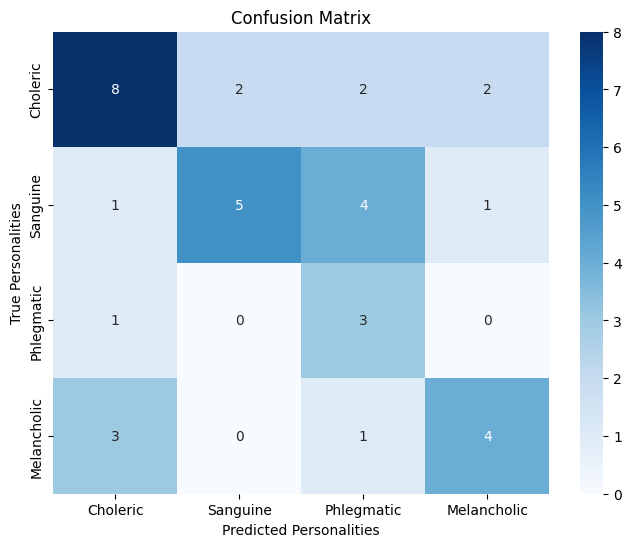

In [ ]:

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr + 0.0001  # Gradually increase during warm-up
    return lr * 0.95  # Gradually decrease after epoch 10

personality_mapping = {
    "choleric": 0,
    "sanguine": 1,
    "phlegmatic": 2,
    "melancholic": 3
}

print(labels_list)
#labels_list = [personality_mapping.get(label, -1) for label in labels_list]

default_label = "choleric"
labels_list = [personality_mapping.get(label, personality_mapping[default_label]) for label in labels_list]

print("Labels list after mapping:", labels_list)

X = np.array(features_list)
y = np.array(labels_list)

# Replace any NaN or inf values in features
X = np.nan_to_num(X)
X = X.astype(np.float32)

print("Labels list before binarization:", labels_list)
arr = np.array(labels_list)
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(labels_list)+1))
y_encoded = label_binarizer.transform(arr)
print('{0}'.format(y_encoded))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42)
kfold = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=42)
fold_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, val_idx in kfold.split(X_train, np.argmax(y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Compute class weights
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train_fold, axis=1)),
        y=np.argmax(y_train_fold, axis=1)
    )
    class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

    model = models.Sequential([
        layers.Input(shape=(X_train_fold.shape[1],)),
        layers.Dense(256),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(128),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(64),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(32),
        layers.LeakyReLU(alpha=leaky_RELU_alpha),
        layers.BatchNormalization(),
        layers.Dense(y_encoded.shape[1], activation='softmax')  # Softmax output
    ])

    model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    lr_scheduler_callback = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

    history = model.fit(X_train_fold, y_train_fold,
                        epochs=epochs,
                        batch_size=batch_size,
                        # validation_data=(X_test_fold, y_test_fold),
                        validation_data=(X_val_fold, y_val_fold),
                        class_weight=class_weights,
                        callbacks=[early_stopping, lr_scheduler_callback],
                        verbose=0)

    # Evaluate model on validation fold
    score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(score[1])

    # Predict on validation data
    predictions = model.predict(X_val_fold)
    # predictions = model.predict(X_test_fold)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_val_fold, axis=1)
    # true_classes = np.argmax(y_test_fold, axis=1)


    # Get unique classes in this fold
    unique_classes_in_fold = np.unique(true_classes)

    # Get target names for the unique classes in this fold
    target_names_in_fold = [label_binarizer.classes_[i] for i in unique_classes_in_fold]
    #label_binarizer is the fitted LabelBinarizer from earlier in your code.
    #This line ensures target_names match the classes actually present in the fold.

    # # Classification report with updated target names
    # report = classification_report(true_classes, predicted_classes, target_names=target_names_in_fold)
    # print(report)


    # # Classification report
    # report = classification_report(true_classes, predicted_classes, target_names=encoder.categories_[0])
    # print(report)

    # Compute per-fold precision, recall, and F1
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Fold Test Accuracy: {score[1] * 100:.2f}%")

# Print average metrics
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies) * 100:.2f}%")
print(f"Average Precision: {np.mean(precision_scores) * 100:.2f}%")
print(f"Average Recall: {np.mean(recall_scores) * 100:.2f}%")
print(f"Average F1-Score: {np.mean(f1_scores) * 100:.2f}%")

  #model, X_test, y_test = run_model(X_scaled, y_encoded)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# run_model(X_scaled, y_encoded)

# labels_list = old_labels_list

# Predict on the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class indices

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Choleric", "Sanguine", "Phlegmatic", "Melancholic"],
            yticklabels=["Choleric", "Sanguine", "Phlegmatic", "Melancholic"])
plt.xlabel("Predicted Personalities")
plt.ylabel("True Personalities")
plt.title("Confusion Matrix")
plt.show()

100%|██████████| 182/182 [00:00<00:00, 12586.37it/s]


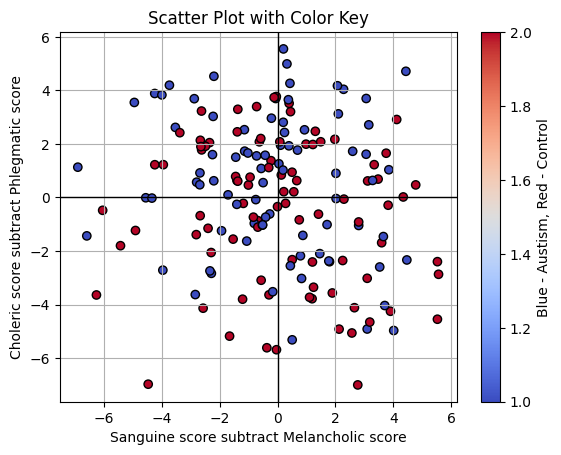

In [ ]:
x = np.array([])
y = np.array([])
z = np.array([])

for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
    x = np.append(x, row["sanguine_score"] - row["melancholic_score"])
    y = np.append(y, row["choleric_score"] - row["phlegmatic_score"])
    z = np.append(z, row["DX_GROUP"])

# Create the scatter plot with a color map
scatter = plt.scatter(x, y, c=z, cmap='coolwarm', edgecolors='k')

# Add a color bar (color key)
plt.colorbar(scatter, label='Blue - Austism, Red - Control')

# Add labels and title
plt.xlabel('Sanguine score subtract Melancholic score')
plt.ylabel('Choleric score subtract Phlegmatic score')
plt.title('Scatter Plot with Color Key')

# Show grid and adjust the axes to ensure positive and negative are both visible
plt.grid(True)
plt.axhline(0, color='black',linewidth=1)  # Horizontal line at y=0
plt.axvline(0, color='black',linewidth=1)  # Vertical line at x=0

# Show the plot
plt.show()

100%|██████████| 182/182 [00:00<00:00, 13879.59it/s]


Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
[[6 1 0 5]
 [6 2 5 6]
 [3 3 0 1]
 [6 2 3 4]
 [2 2 1 2]
 [4 1 2 5]
 [1 1 5 1]]
[[ 5  4  3  2]
 [ 4  5  2  6]
 [ 5  6  2  1]
 [ 1  4  3  5]
 [ 2  2 10  1]
 [ 4  2  3  7]
 [ 0  1  0  1]]


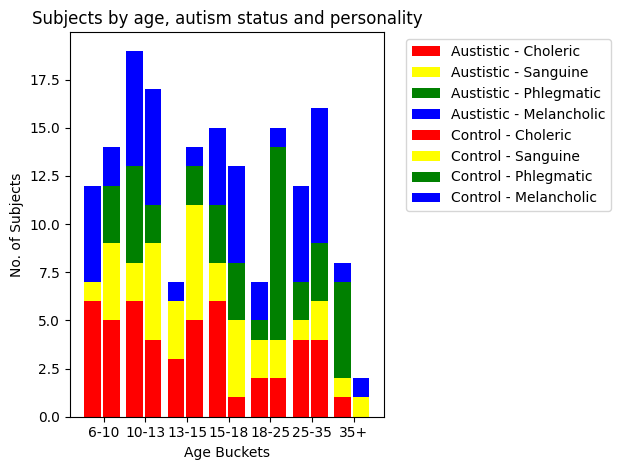

In [ ]:
def get_age_group_index(age):
  if age < 10:
    return 0
  elif age < 13:
    return 1
  elif age < 15:
    return 2
  elif age < 18:
    return 3
  elif age < 25:
    return 4
  elif age < 35:
    return 5
  else:
    return 6

# Example data
categories = ["6-10", "10-13", "13-15", "15-18", "18-25", "25-35", "35+"]  # Categories for the x-axis

personality_encoding = {"choleric": 0, "sanguine": 1, "phlegmatic": 2, "melancholic": 3}

autistic_group = np.array([[0, 0, 0, 0],   # Stacked values for group 1 (first bar of each pair)
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])  # Values for 4 categories

control_group = np.array([[0, 0, 0, 0],   # Stacked values for group 2 (second bar of each pair)
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])

for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
  try:
      if row["DX_GROUP"] == 1:
        autistic_group[get_age_group_index(row["AGE_AT_SCAN"])][personality_encoding[row["PERSONALITY"]]] += 1
      else:
        control_group[get_age_group_index(row["AGE_AT_SCAN"])][personality_encoding[row["PERSONALITY"]]] += 1
  except KeyError as e:
      print("Key error, continue to next subject")
      continue

# Number of categories
n = len(categories)

# Bar positions
x = np.arange(n)  # Create positions for each category
bar_width = 0.4   # Width of each bar

print(autistic_group)
print(control_group)

# Create the stacked bar chart

# Stacked bar chart for Group 1
plt.bar(x - bar_width / 1.5, autistic_group[:, 0], width=bar_width, label='Austistic - Choleric', color='red')
plt.bar(x - bar_width / 1.5, autistic_group[:, 1], width=bar_width, bottom=autistic_group[:, 0], label='Austistic - Sanguine', color='yellow')
plt.bar(x - bar_width / 1.5, autistic_group[:, 2], width=bar_width, bottom=autistic_group[:, 0] + autistic_group[:, 1], label='Austistic - Phlegmatic', color='green')
plt.bar(x - bar_width / 1.5, autistic_group[:, 3], width=bar_width, bottom=autistic_group[:, 0] + autistic_group[:, 1] + autistic_group[:, 2], label='Austistic - Melancholic', color='blue')

# Stacked bar chart for Group 2
plt.bar(x + bar_width / 2.2, control_group[:, 0], width=bar_width, label='Control - Choleric', color='red')
plt.bar(x + bar_width / 2.2, control_group[:, 1], width=bar_width, bottom=control_group[:, 0], label='Control - Sanguine', color='yellow')
plt.bar(x + bar_width / 2.2, control_group[:, 2], width=bar_width, bottom=control_group[:, 0] + control_group[:, 1], label='Control - Phlegmatic', color='green')
plt.bar(x + bar_width / 2.2, control_group[:, 3], width=bar_width, bottom=control_group[:, 0] + control_group[:, 1] + control_group[:, 2], label='Control - Melancholic', color='blue')

# Add labels, title, and legend
plt.xlabel('Age Buckets')
plt.ylabel('No. of Subjects')
plt.title('Subjects by age, autism status and personality')
plt.xticks(x, categories)  # Add category labels to x-axis
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Place legend outside the plot

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()
